# SET UP

In [1]:
!pip install -q mne hmmlearn
!pip install -q xgboost

print("Đã cài đặt xong thư viện!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 5.0 MB/s eta 0:00:00
Đã cài đặt xong thư viện!


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from hmmlearn import hmm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print(f"MNE version: {mne.__version__}")
print(f"Numpy version: {np.__version__}")

MNE version: 1.10.2
Numpy version: 1.26.4


In [3]:
base_path = '/kaggle/input/eeg-dataset'

def find_eeg_files(root_dir):
    vhdr_files = []
    print(f"Đang quét dữ liệu trong: {root_dir} ...")
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".vhdr"):
                full_path = os.path.join(root, file)
                vhdr_files.append(full_path)
                print(f"Tìm thấy: {file}")
    
    if not vhdr_files:
        print("CẢNH BÁO: Không tìm thấy file .vhdr nào! Hãy kiểm tra lại dataset bạn đã add.")
    else:
        print(f"\nTổng cộng tìm thấy {len(vhdr_files)} files.")
        
    return vhdr_files

list_files = find_eeg_files(base_path)

list_files.sort()

Đang quét dữ liệu trong: /kaggle/input/eeg-dataset ...
Tìm thấy: sub-01_task-oddball_eeg.vhdr
Tìm thấy: sub-02_task-oddball_eeg.vhdr
Tìm thấy: sub-03_task-oddball_eeg.vhdr
Tìm thấy: sub-05_task-oddball_eeg.vhdr
Tìm thấy: sub-04_task-oddball_eeg.vhdr

Tổng cộng tìm thấy 5 files.


Đang thử load file: /kaggle/input/eeg-dataset/sub-01_task-oddball_eeg.vhdr

--- THÔNG TIN DỮ LIỆU ---
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9 LEFT EAR, CP5, CP1, ...
 chs: 127 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 127
 projs: []
 sfreq: 1000.0 Hz
>
Tên các kênh (Channels): ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9 LEFT EAR', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10 RIGHT EAR', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'F9', 'AFF1h', 'FFC1h', 'FFC5h', 'FTT7h', 'FCC3h', 'CCP1h', 'CCP5h', 'TPP7h', 'P9', 'PPO9h', 'PO9', 'O9', 'OI1h', 'PPO1h', 'CPP3h', 'CPP4h', 'PPO2h', 'OI2h', 'O10', 'PO10', 'PPO10

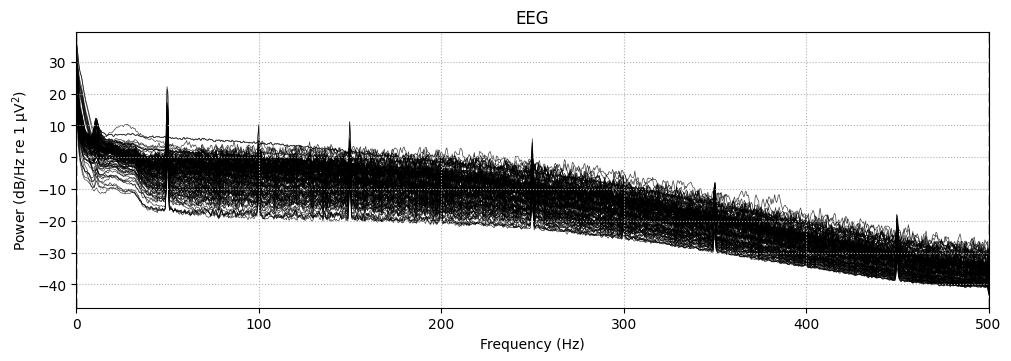

In [4]:
if list_files:
    sample_file = list_files[0]
    
    print(f"Đang thử load file: {sample_file}")
    
    raw = mne.io.read_raw_brainvision(sample_file, preload=True, verbose=False)
    
    print("\n--- THÔNG TIN DỮ LIỆU ---")
    print(raw.info)
    print(f"Tên các kênh (Channels): {raw.ch_names}")
    print(f"Tần số lấy mẫu (Sampling Rate): {raw.info['sfreq']} Hz")
    
    raw.compute_psd().plot()
    plt.show()
    
else:
    print("Không có dữ liệu để kiểm tra.")

# Preprocessing

In [5]:
sample_file = list_files[0]
raw_temp = mne.io.read_raw_brainvision(sample_file, preload=False, verbose=False)
events, event_dict = mne.events_from_annotations(raw_temp, verbose=False)

print("--- DANH SÁCH CÁC SỰ KIỆN TÌM THẤY ---")
print(event_dict)

print("\n--- SỐ LƯỢNG MỖI SỰ KIỆN ---")
unique, counts = np.unique(events[:, 2], return_counts=True)
for u, c in zip(unique, counts):
    name = [k for k, v in event_dict.items() if v == u][0]
    print(f"Event ID {u} ({name}): {c} lần")

--- DANH SÁCH CÁC SỰ KIỆN TÌM THẤY ---
{'New Segment/': 99999, 'Stimulus/S  1': 1, 'Stimulus/S  5': 5, 'Stimulus/S  6': 6, 'Stimulus/S  7': 7, 'Stimulus/S 10': 10, 'Stimulus/S 12': 12, 'Time 0/': 10001}

--- SỐ LƯỢNG MỖI SỰ KIỆN ---
Event ID 1 (Stimulus/S  1): 107 lần
Event ID 5 (Stimulus/S  5): 498 lần
Event ID 6 (Stimulus/S  6): 81 lần
Event ID 7 (Stimulus/S  7): 81 lần
Event ID 10 (Stimulus/S 10): 4 lần
Event ID 12 (Stimulus/S 12): 3 lần
Event ID 10001 (Time 0/): 1 lần
Event ID 99999 (New Segment/): 1 lần


In [6]:
target_name = 'Stimulus/S  6'   
frequent_name = 'Stimulus/S  5' 

l_freq = 1.0  
h_freq = 30.0 

tmin = -0.1 
tmax = 0.8  

In [7]:
def process_subject(file_path):
    raw = mne.io.read_raw_brainvision(file_path, preload=True, verbose=False)
    
    target_channels = ['Pz', 'Cz', 'Fz', 'P3', 'P4', 'CPz', 'POz', 'Oz'] 
    available_channels = [ch for ch in target_channels if ch in raw.ch_names]
    
    if available_channels:
        raw.pick_channels(available_channels)
    
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore') 
  
    raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)
    
    # SỬA: Resample trước khi cắt Epochs để tránh méo tín hiệu
    if raw.info['sfreq'] > 128:
        raw.resample(128)

    events, event_id_map = mne.events_from_annotations(raw, verbose=False)

    if target_name not in event_id_map or frequent_name not in event_id_map:
        return None

    my_event_id = {
        'Target': event_id_map[target_name],
        'Frequent': event_id_map[frequent_name]
    }

    # SỬA: baseline=(None, 0) an toàn hơn
    epochs = mne.Epochs(raw, events, event_id=my_event_id, 
                        tmin=tmin, tmax=tmax, 
                        baseline=(None, 0), preload=True, verbose=False)
        
    return epochs

In [8]:
all_epochs_list = []
subject_names = []

print(f"Bắt đầu xử lý {len(list_files)} subjects...")

for i, file_path in enumerate(list_files):
    sub_name = os.path.basename(file_path).split('.')[0]
    print(f"[{i+1}/{len(list_files)}] Đang xử lý: {sub_name}")
    
    epochs = process_subject(file_path)
    
    if epochs is not None:
        all_epochs_list.append(epochs)
        subject_names.append(sub_name)
        
        n_tar = len(epochs['Target'])
        n_freq = len(epochs['Frequent'])
        print(f"   -> Kết quả: {n_tar} Target, {n_freq} Frequent trials.")

print("\nĐã xử lý xong toàn bộ Giai đoạn 2!")

Bắt đầu xử lý 5 subjects...
[1/5] Đang xử lý: sub-01_task-oddball_eeg
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
   -> Kết quả: 81 Target, 498 Frequent trials.
[2/5] Đang xử lý: sub-02_task-oddball_eeg
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
   -> Kết quả: 81 Target, 498 Frequent trials.
[3/5] Đang xử lý: sub-03_task-oddball_eeg
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
   -> Kết quả: 81 Target, 498 Frequent trials.
[4/5] Đang xử lý: sub-04_task-oddball_eeg
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
   -> Kết quả: 81 Target, 498 Frequent trials.
[5/5] Đang xử lý: sub-05_task-oddball_eeg
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
   -> Kết quả: 81 Target, 498 Frequent trials.

Đã xử lý xong toàn bộ Giai đoạn 2!


# Balance data & Classification

In [9]:
def get_full_dataset(epochs):
    X_target = epochs['Target'].get_data(copy=True)
    X_frequent = epochs['Frequent'].get_data(copy=True)
    
    X_raw = np.concatenate((X_target, X_frequent), axis=0)
    y = np.concatenate((np.ones(len(X_target)), np.zeros(len(X_frequent))), axis=0)
    return X_raw, y

def undersample_training_data(X, y):
    """Chỉ cân bằng dữ liệu Train"""
    idx_1 = np.where(y == 1)[0]
    idx_0 = np.where(y == 0)[0]
    
    if len(idx_0) > len(idx_1):
        idx_0 = np.random.choice(idx_0, size=len(idx_1), replace=False)
        
    idx_bal = np.concatenate((idx_1, idx_0))
    np.random.shuffle(idx_bal)
    return X[idx_bal], y[idx_bal]

--- STARTING EXTENSIVE BENCHMARK WITH TUNING ---

PROCESSING: sub-01_task-oddball_eeg
  > Results for sub-01_task-oddball_eeg:
    - LDA: 0.5665
    - LogisticRegression: 0.6009
    - SVM: 0.5994
    - RandomForest: 0.6269
    - XGBoost: 0.5907

PROCESSING: sub-02_task-oddball_eeg
  > Results for sub-02_task-oddball_eeg:
    - LDA: 0.7513
    - LogisticRegression: 0.7633
    - SVM: 0.7667
    - RandomForest: 0.7287
    - XGBoost: 0.7391

PROCESSING: sub-03_task-oddball_eeg
  > Results for sub-03_task-oddball_eeg:
    - LDA: 0.8549
    - LogisticRegression: 0.8359
    - SVM: 0.8376
    - RandomForest: 0.8291
    - XGBoost: 0.7893

PROCESSING: sub-04_task-oddball_eeg
  > Results for sub-04_task-oddball_eeg:
    - LDA: 0.7806
    - LogisticRegression: 0.7789
    - SVM: 0.7634
    - RandomForest: 0.7651
    - XGBoost: 0.7461

PROCESSING: sub-05_task-oddball_eeg
  > Results for sub-05_task-oddball_eeg:
    - LDA: 0.8722
    - LogisticRegression: 0.8878
    - SVM: 0.8619
    - RandomForest: 

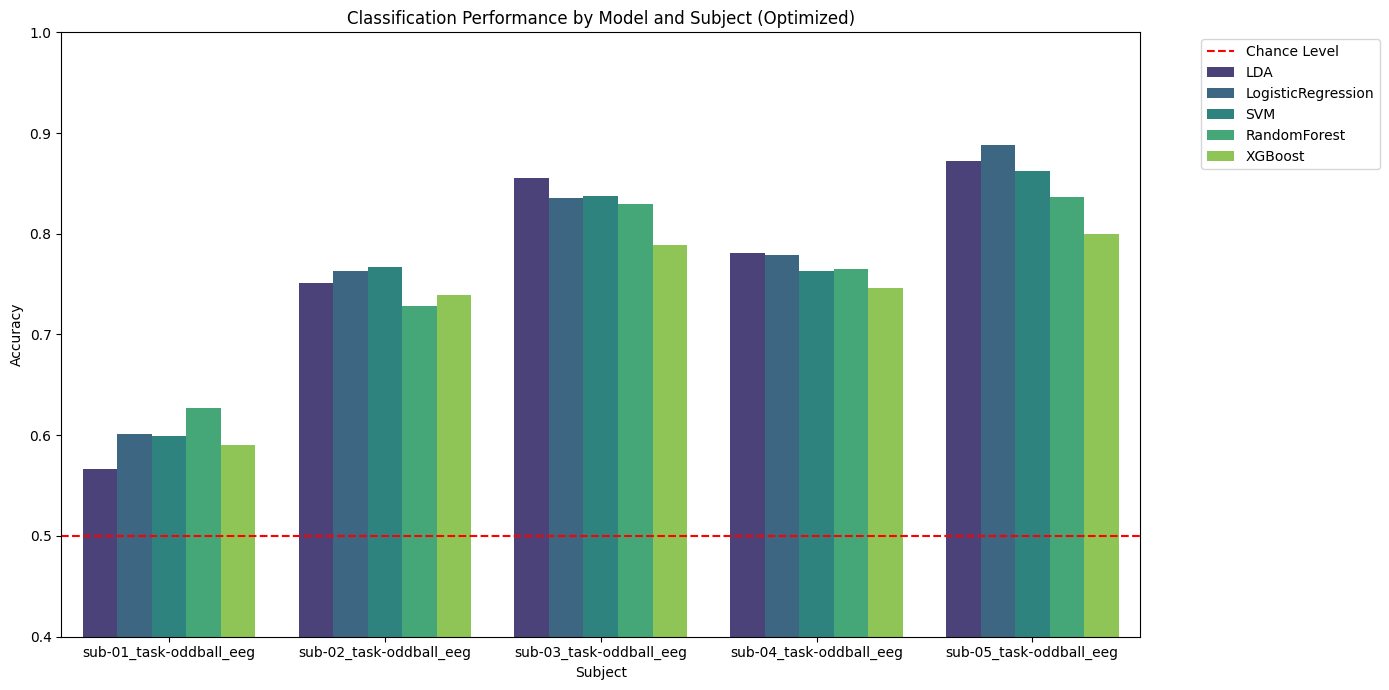

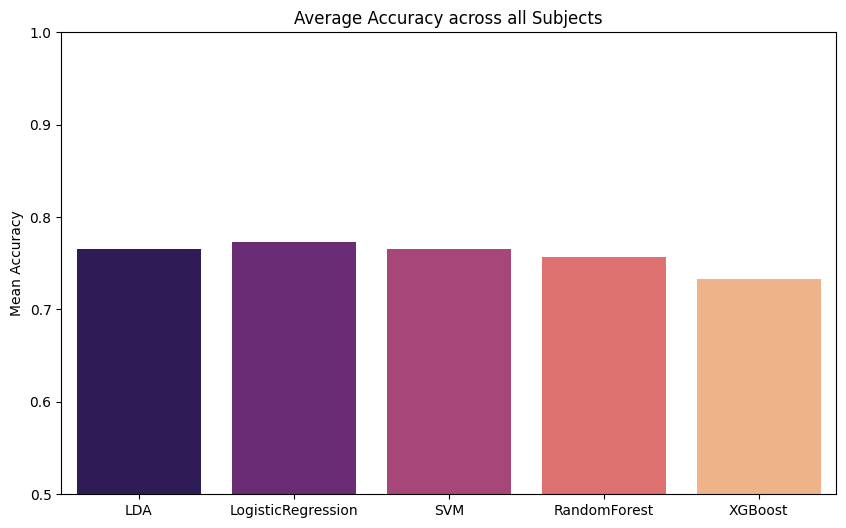

In [10]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

# 1. Cấu hình các mô hình và không gian tham số (Hyperparameter Space)
# Lưu ý: n_jobs=-1 để tận dụng đa luồng CPU
model_configs = {
    'LDA': {
        'model': LinearDiscriminantAnalysis(),
        'params': [
            {'clf__solver': ['svd']},
            {'clf__solver': ['lsqr', 'eigen'], 'clf__shrinkage': ['auto', 0.1, 0.5, None]}
        ]
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__solver': ['lbfgs', 'liblinear']
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            # gamma='scale' là mặc định tốt, có thể tune thêm nếu cần
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'clf__n_estimators': [50, 100],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 5]
        }
    }
}

# Dictionary để lưu kết quả chi tiết
final_results = {name: [] for name in model_configs.keys()}
subject_scores_detail = [] # Dùng để vẽ bảng sau này

print("--- STARTING EXTENSIVE BENCHMARK WITH TUNING ---")

# Vòng lặp qua từng Subject
for i, epochs in enumerate(all_epochs_list):
    sub_name = subject_names[i]
    print(f"\nPROCESSING: {sub_name}")
    
    # 2. Lấy dữ liệu và Flatten
    X_raw, y = get_full_dataset(epochs)
    # Flatten: (Trials, Channels, Time) -> (Trials, Features)
    X_flat = X_raw.reshape(X_raw.shape[0], -1)
    
    # Chuẩn bị K-Fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Dictionary tạm để lưu acc của từng model cho subject này
    sub_model_accs = {name: [] for name in model_configs.keys()}
    
    # Vòng lặp Cross-Validation
    for fold_idx, (train_ix, test_ix) in enumerate(cv.split(X_flat, y)):
        X_train, X_test = X_flat[train_ix], X_flat[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        
        # 3. QUAN TRỌNG: Cân bằng dữ liệu (Undersampling) chỉ trên tập Train
        X_train_bal, y_train_bal = undersample_training_data(X_train, y_train)
        
        # Vòng lặp qua từng Model
        for model_name, config in model_configs.items():
            # Tạo Pipeline: Scaler -> Model
            # Đặt tên bước model là 'clf' để khớp với params grid ở trên
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', config['model'])
            ])
            
            # Grid Search (Tuning)
            # cv=3 trong grid search để tiết kiệm thời gian (inner loop)
            search = GridSearchCV(
                pipeline, 
                config['params'], 
                cv=3, 
                scoring='accuracy', 
                n_jobs=-1
            )
            
            # Train trên dữ liệu cân bằng
            search.fit(X_train_bal, y_train_bal)
            
            # Đánh giá trên tập Test (dữ liệu gốc, không cân bằng, giữ nguyên tỷ lệ thực tế)
            # Hoặc tập test cũng được coi là đại diện phân phối thực
            best_model = search.best_estimator_
            acc = best_model.score(X_test, y_test)
            
            sub_model_accs[model_name].append(acc)
            
    # Tính trung bình accuracy của Subject này cho từng model
    print(f"  > Results for {sub_name}:")
    for model_name, accs in sub_model_accs.items():
        mean_acc = np.mean(accs)
        final_results[model_name].append(mean_acc)
        
        # Lưu chi tiết để tạo DataFrame
        subject_scores_detail.append({
            'Subject': sub_name,
            'Model': model_name,
            'Accuracy': mean_acc
        })
        print(f"    - {model_name}: {mean_acc:.4f}")

# --- TỔNG HỢP KẾT QUẢ ---
print("\n" + "="*40)
print("FINAL BENCHMARK RESULTS (Mean across 5 subjects)")
print("="*40)

mean_scores = {}
for model_name, accs in final_results.items():
    avg_score = np.mean(accs)
    mean_scores[model_name] = avg_score
    print(f"{model_name:20s}: {avg_score:.4f}")

best_model_name = max(mean_scores, key=mean_scores.get)
print("-" * 40)
print(f"🏆 BEST MODEL: {best_model_name} with {mean_scores[best_model_name]:.4f} accuracy")
print("="*40)

# --- VISUALIZATION ---
df_results = pd.DataFrame(subject_scores_detail)

plt.figure(figsize=(14, 7))
# Vẽ biểu đồ nhóm
sns.barplot(data=df_results, x='Subject', y='Accuracy', hue='Model', palette='viridis')
plt.title('Classification Performance by Model and Subject (Optimized)')
plt.ylim(0.4, 1.0)
plt.axhline(0.5, color='red', linestyle='--', label='Chance Level')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Vẽ biểu đồ tổng hợp trung bình
plt.figure(figsize=(10, 6))
sns.barplot(x=list(mean_scores.keys()), y=list(mean_scores.values()), palette='magma')
plt.title('Average Accuracy across all Subjects')
plt.ylim(0.5, 1.0)
plt.ylabel('Mean Accuracy')
plt.show()

In [13]:
results_baseline = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))

print("--- TASK 1: BASELINE (CORRECTED) ---")

for i, epochs in enumerate(all_epochs_list):
    sub = subject_names[i]
    X_raw, y = get_full_dataset(epochs)
    X_flat = X_raw.reshape(X_raw.shape[0], -1)
    
    fold_acc = []
    for train_ix, test_ix in cv.split(X_flat, y):
        X_train, X_test = X_flat[train_ix], X_flat[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        
        X_train_bal, y_train_bal = undersample_training_data(X_train, y_train)
        
        base_clf.fit(X_train_bal, y_train_bal)
        fold_acc.append(base_clf.score(X_test, y_test))
        
    mean_acc = np.mean(fold_acc)
    results_baseline.append(mean_acc)
    print(f"Subject {sub}: Accuracy = {mean_acc:.4f}")

--- TASK 1: BASELINE (CORRECTED) ---
Subject sub-01_task-oddball_eeg: Accuracy = 0.5682
Subject sub-02_task-oddball_eeg: Accuracy = 0.7668
Subject sub-03_task-oddball_eeg: Accuracy = 0.8394
Subject sub-04_task-oddball_eeg: Accuracy = 0.7755
Subject sub-05_task-oddball_eeg: Accuracy = 0.8809


# HMM feature extracting

In [11]:
def extract_hmm_features(hmm_t, hmm_f, X_data):
    feats = []
    for trial in X_data:
        try:
            # Lấy Log-Likelihood: độ khớp với mô hình Target vs Frequent
            score_t = hmm_t.score(trial)
            score_f = hmm_f.score(trial)
            feats.append([score_t, score_f, score_t - score_f])
        except:
            feats.append([0, 0, 0])
    return np.array(feats)

In [12]:
from sklearn.metrics import accuracy_score

def run_hmm_pipeline(epochs, n_states=3):
    X_raw, y = get_full_dataset(epochs)
    X_hmm = np.transpose(X_raw, (0, 2, 1)) # (N, T, C)
    X_flat = X_raw.reshape(X_raw.shape[0], -1)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_ix, test_ix in cv.split(X_raw, y):
        X_train_h, X_test_h = X_hmm[train_ix], X_hmm[test_ix]
        X_train_f, X_test_f = X_flat[train_ix], X_flat[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        
        # Scale HMM input
        n_tr, n_t, n_c = X_train_h.shape
        scaler = StandardScaler()
        
        # Fit scaler trên train, transform cả train và test
        X_train_h_sc = scaler.fit_transform(X_train_h.reshape(-1, n_c)).reshape(n_tr, n_t, n_c)
        X_test_h_sc = scaler.transform(X_test_h.reshape(-1, n_c)).reshape(X_test_h.shape[0], n_t, n_c)
        
        # Train HMMs trên tập Train
        X_T = X_train_h_sc[y_train==1]
        X_F = X_train_h_sc[y_train==0]
        
        # Downsample X_F để train nhanh hơn nếu cần
        if len(X_F) > len(X_T)*2:
            X_F = X_F[np.random.choice(len(X_F), len(X_T)*2, replace=False)]

        params = {"n_components": n_states, "covariance_type": "diag", "n_iter": 50, "verbose": False}
        
        hmm_t = hmm.GaussianHMM(**params).fit(np.vstack(X_T), [n_t]*len(X_T))
        hmm_f = hmm.GaussianHMM(**params).fit(np.vstack(X_F), [n_t]*len(X_F))
        
        # Extract features
        F_train = extract_hmm_features(hmm_t, hmm_f, X_train_h_sc)
        F_test = extract_hmm_features(hmm_t, hmm_f, X_test_h_sc)
        
        # Combine & Classify
        X_train_combo = np.hstack((X_train_f, F_train))
        X_test_combo = np.hstack((X_test_f, F_test))
        
        X_train_fin, y_train_fin = undersample_training_data(X_train_combo, y_train)
        
        clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
        clf.fit(X_train_fin, y_train_fin)
        scores.append(accuracy_score(y_test, clf.predict(X_test_combo)))
        
    return np.mean(scores)

results_hmm_optimized = []
print("--- TASK 2: HMM OPTIMIZED (CORRECTED) ---")

for i, epochs in enumerate(all_epochs_list):
    try:
        acc = run_hmm_pipeline(epochs)
        results_hmm_optimized.append(acc)
        print(f"Subject {subject_names[i]}: Combined Acc = {acc:.4f}")
    except Exception as e:
        print(f"Error {subject_names[i]}: {e}")
        results_hmm_optimized.append(results_baseline[i])

--- TASK 2: HMM OPTIMIZED (CORRECTED) ---
Subject sub-01_task-oddball_eeg: Combined Acc = 0.6027
Subject sub-02_task-oddball_eeg: Combined Acc = 0.7943
Subject sub-03_task-oddball_eeg: Combined Acc = 0.8359
Subject sub-04_task-oddball_eeg: Combined Acc = 0.7790
Subject sub-05_task-oddball_eeg: Combined Acc = 0.8809


# Visualize

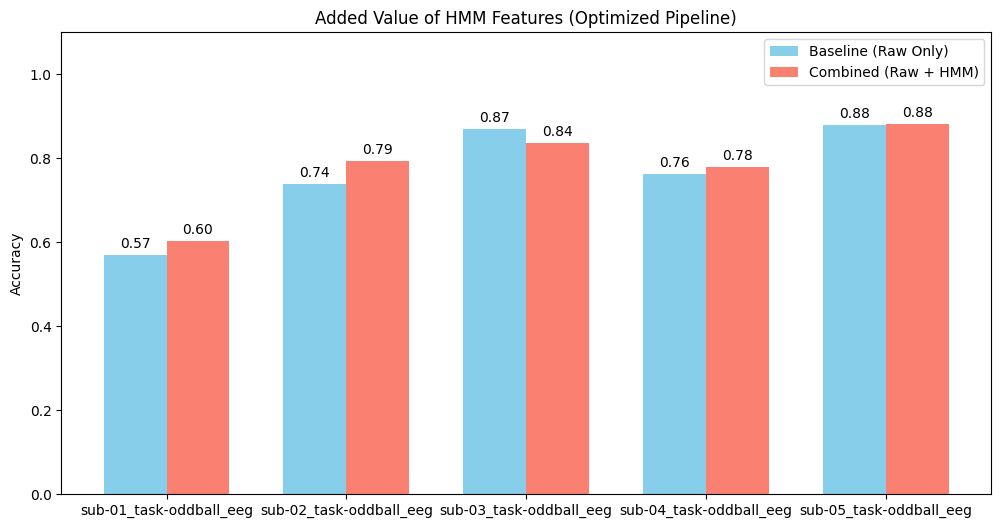

Mean Baseline: 0.7637
Mean Combined: 0.7786
Gain: 1.48%


In [13]:
# Thiết lập vị trí các cột
x = np.arange(len(subject_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, results_baseline, width, label='Baseline (Raw Only)', color='skyblue')
rects2 = ax.bar(x + width/2, results_hmm_optimized, width, label='Combined (Raw + HMM)', color='salmon')

# Trang trí biểu đồ
ax.set_ylabel('Accuracy')
ax.set_title('Added Value of HMM Features (Optimized Pipeline)')
ax.set_xticks(x)
ax.set_xticklabels(subject_names)
ax.legend()
ax.set_ylim(0, 1.1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

mean_base = np.mean(results_baseline)
mean_opt = np.mean(results_hmm_optimized)
print(f"Mean Baseline: {mean_base:.4f}")
print(f"Mean Combined: {mean_opt:.4f}")
print(f"Gain: {(mean_opt - mean_base)*100:.2f}%")

# Test

In [13]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- 1. CÁC HÀM HỖ TRỢ ---
def get_data_arrays(epochs):
    X_target = epochs['Target'].get_data(copy=True)
    X_freq = epochs['Frequent'].get_data(copy=True)
    X = np.concatenate([X_target, X_freq], axis=0)
    y = np.concatenate([np.ones(len(X_target)), np.zeros(len(X_freq))], axis=0)
    X = np.transpose(X, (0, 2, 1)) 
    return X, y

def undersample_training_data(X, y):
    idx_1 = np.where(y == 1)[0]
    idx_0 = np.where(y == 0)[0]
    if len(idx_0) > len(idx_1):
        idx_0 = np.random.choice(idx_0, size=len(idx_1), replace=False)
    idx_bal = np.concatenate((idx_1, idx_0))
    np.random.shuffle(idx_bal)
    return X[idx_bal], y[idx_bal]

def extract_hmm_features(hmm_t, hmm_f, X_data):
    feats = []
    for trial in X_data:
        try:
            score_t = hmm_t.score(trial)
            score_f = hmm_f.score(trial)
            feats.append([score_t, score_f, score_t - score_f])
        except:
            feats.append([0, 0, 0])
    return np.array(feats)

# --- 2. CẤU HÌNH GRID SEARCH ---
model_configs = {
    'LDA': {
        'model': LinearDiscriminantAnalysis(),
        'params': [{'clf__solver': ['lsqr'], 'clf__shrinkage': ['auto', 0.1, 0.5, None]}]
    },
    'LogReg': {
        'model': LogisticRegression(max_iter=2000, random_state=42),
        'params': {'clf__C': [0.1, 1, 10], 'clf__solver': ['lbfgs', 'liblinear']}
    },
    'SVM': {
        'model': SVC(random_state=42, cache_size=500),
        'params': {'clf__C': [1, 10, 100], 'clf__kernel': ['rbf', 'linear'], 'clf__gamma': ['scale', 'auto']}
    }
}

# --- 3. HÀM CHẠY BENCHMARK ---
def run_full_benchmark_with_params(all_epochs, subjects):
    results = []
    best_params_history = [] # Lưu lịch sử tham số tốt nhất
    
    # HMM Config
    n_states = 3
    hmm_params = {"n_components": n_states, "covariance_type": "diag", "n_iter": 50, "verbose": False, "random_state": 42}

    print("--- STARTING FULL BENCHMARK (Raw vs Raw+HMM) ---")
    
    for i, epochs in enumerate(all_epochs):
        sub_name = subjects[i]
        print(f" -> Processing: {sub_name}")
        
        # Data Prep
        X_orig_hmm, y_orig = get_data_arrays(epochs) 
        X_orig_flat = X_orig_hmm.reshape(X_orig_hmm.shape[0], -1) 
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Lưu kết quả từng fold
        scores_raw = {name: [] for name in model_configs}
        scores_hmm = {name: [] for name in model_configs}
        
        # Lưu tham số tốt nhất của từng fold (để tính mode hoặc lấy mẫu)
        params_raw_fold = {name: [] for name in model_configs}
        params_hmm_fold = {name: [] for name in model_configs}
        
        for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_orig_hmm, y_orig)):
            y_train, y_test = y_orig[train_idx], y_orig[test_idx]
            
            # --- NHÁNH 1: BASELINE (RAW ONLY) ---
            X_train_raw, X_test_raw = X_orig_flat[train_idx], X_orig_flat[test_idx]
            X_train_raw_bal, y_train_bal = undersample_training_data(X_train_raw, y_train)
            
            for name, config in model_configs.items():
                pipe = Pipeline([('scaler', StandardScaler()), ('clf', config['model'])])
                search = GridSearchCV(pipe, config['params'], cv=3, scoring='accuracy', n_jobs=-1)
                search.fit(X_train_raw_bal, y_train_bal)
                
                scores_raw[name].append(accuracy_score(y_test, search.predict(X_test_raw)))
                params_raw_fold[name].append(search.best_params_) # Lưu tham số tốt nhất

            # --- NHÁNH 2: RAW + HMM ---
            X_train_h, X_test_h = X_orig_hmm[train_idx], X_orig_hmm[test_idx]
            
            # Scale & Train HMM (Downsample 2:1)
            n_tr, n_t, n_c = X_train_h.shape
            scaler = StandardScaler()
            X_train_h_sc = scaler.fit_transform(X_train_h.reshape(-1, n_c)).reshape(n_tr, n_t, n_c)
            X_test_h_sc = scaler.transform(X_test_h.reshape(-1, n_c)).reshape(X_test_h.shape[0], n_t, n_c)
            
            X_T = X_train_h_sc[y_train==1]
            X_F = X_train_h_sc[y_train==0]
            
            if len(X_F) > len(X_T)*2:
                np.random.seed(42)
                X_F = X_F[np.random.choice(len(X_F), len(X_T)*2, replace=False)]

            hmm_t = hmm.GaussianHMM(**hmm_params).fit(np.vstack(X_T), [n_t]*len(X_T))
            hmm_f = hmm.GaussianHMM(**hmm_params).fit(np.vstack(X_F), [n_t]*len(X_F))
            
            F_train = extract_hmm_features(hmm_t, hmm_f, X_train_h_sc)
            F_test = extract_hmm_features(hmm_t, hmm_f, X_test_h_sc)
            
            X_train_combo = np.hstack((X_train_raw, F_train))
            X_test_combo = np.hstack((X_test_raw, F_test))
            
            X_train_combo_bal, y_train_bal_combo = undersample_training_data(X_train_combo, y_train)
            
            for name, config in model_configs.items():
                pipe = Pipeline([('scaler', StandardScaler()), ('clf', config['model'])])
                search = GridSearchCV(pipe, config['params'], cv=3, scoring='accuracy', n_jobs=-1)
                search.fit(X_train_combo_bal, y_train_bal_combo)
                
                scores_hmm[name].append(accuracy_score(y_test, search.predict(X_test_combo)))
                params_hmm_fold[name].append(search.best_params_) # Lưu tham số tốt nhất
        
        # Tổng hợp kết quả và tham số
        for name in model_configs:
            # Lấy tham số phổ biến nhất (mode) hoặc tham số của fold cuối cùng
            # Ở đây ta lấy tham số của fold cuối cùng làm đại diện
            best_p_raw = params_raw_fold[name][-1]
            best_p_hmm = params_hmm_fold[name][-1]
            
            # Format lại chuỗi tham số cho gọn
            # Loại bỏ prefix 'clf__' để dễ đọc
            clean_p_raw = {k.replace('clf__', ''): v for k, v in best_p_raw.items()}
            clean_p_hmm = {k.replace('clf__', ''): v for k, v in best_p_hmm.items()}

            results.append({
                'Subject': sub_name,
                'Model': name,
                'FeatureType': 'Raw',
                'Accuracy': np.mean(scores_raw[name]),
                'Best Params': str(clean_p_raw)
            })
            results.append({
                'Subject': sub_name,
                'Model': name,
                'FeatureType': 'Raw+HMM',
                'Accuracy': np.mean(scores_hmm[name]),
                'Best Params': str(clean_p_hmm)
            })
            
    return pd.DataFrame(results)

# --- CHẠY VÀ HIỂN THỊ ---
df_final = run_full_benchmark_with_params(all_epochs_list, subject_names)

# 1. Bảng Pivot Accuracy (Như cũ)
pivot_acc = df_final.pivot_table(index=['Subject', 'Model'], columns='FeatureType', values='Accuracy')
pivot_acc['Gain'] = pivot_acc['Raw+HMM'] - pivot_acc['Raw']
print("\n=== FINAL ACCURACY COMPARISON ===")
print(pivot_acc)

# 2. Bảng Pivot Best Params (Mới)
pivot_params = df_final.pivot_table(index=['Subject', 'Model'], columns='FeatureType', values='Best Params', aggfunc='first')
print("\n=== BEST HYPERPARAMETERS FOUND ===")
# Set option để hiển thị hết nội dung cột
pd.set_option('display.max_colwidth', None)
print(pivot_params)

--- STARTING FULL BENCHMARK (Raw vs Raw+HMM) ---
 -> Processing: sub-01_task-oddball_eeg
 -> Processing: sub-02_task-oddball_eeg
 -> Processing: sub-03_task-oddball_eeg
 -> Processing: sub-04_task-oddball_eeg
 -> Processing: sub-05_task-oddball_eeg

=== FINAL ACCURACY COMPARISON ===
FeatureType                          Raw   Raw+HMM      Gain
Subject                 Model                               
sub-01_task-oddball_eeg LDA     0.566477  0.587241  0.020765
                        LogReg  0.588951  0.578591 -0.010360
                        SVM     0.630480  0.600945 -0.029535
sub-02_task-oddball_eeg LDA     0.771919  0.778906  0.006987
                        LogReg  0.766837  0.782384  0.015547
                        SVM     0.770285  0.780690  0.010405
sub-03_task-oddball_eeg LDA     0.858456  0.867046  0.008591
                        LogReg  0.841184  0.860120  0.018936
                        SVM     0.834273  0.855037  0.020765
sub-04_task-oddball_eeg LDA     0.773778  0.7

In [18]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# --- CẤU HÌNH ---
N_XDAWN_COMPONENTS = 3  # Số bộ lọc xDAWN (mỗi lớp)
N_HMM_STATES = 3        # Số trạng thái HMM

# --- 1. CÁC HÀM HỖ TRỢ ---
def extract_hmm_features(hmm_t, hmm_f, X_data):
    """X_data shape: (N_trials, N_times, N_channels)"""
    feats = []
    for trial in X_data:
        try:
            s_t = hmm_t.score(trial)
            s_f = hmm_f.score(trial)
            feats.append([s_t, s_f, s_t - s_f])
        except:
            feats.append([0, 0, 0])
    return np.array(feats)

# Tham số cho GridSearch của từng model
param_grids = {
    'LDA': {'clf__solver': ['lsqr'], 'clf__shrinkage': ['auto', 0.1, 0.5]},
    'LogReg': {'clf__C': [0.1, 1, 10], 'clf__solver': ['liblinear']},
    'SVM': {'clf__C': [1, 10], 'clf__kernel': ['rbf'], 'clf__gamma': ['scale'], 'clf__probability': [True]}
}

def run_xdawn_hmm_ensemble(all_epochs_list, subject_names):
    results = []
    
    print("--- RUNNING ADVANCED PIPELINE: xDAWN -> (Raw vs Raw+HMM) -> Ensemble ---")
    
    for i, epochs in enumerate(all_epochs_list):
        sub_name = subject_names[i]
        print(f" -> Processing: {sub_name}")
        
        # 1. Lấy dữ liệu (MNE Epochs Data)
        X = epochs.get_data() # (N, Ch, Time)
        epochs_all = epochs
        
        # Lấy nhãn y (Target=1, Frequent=0)
        # Giả sử logic cũ: events[:, -1] chứa event id
        # Target ID thường là số lớn hơn hoặc check dict
        events = epochs.events[:, -1]
        target_id = [k for k, v in epochs.event_id.items() if 'Target' in k]
        if target_id:
            target_val = epochs.event_id[target_id[0]]
            y = np.where(events == target_val, 1, 0)
        else:
            # Fallback nếu không tìm thấy tên Target
            y = np.where(events == np.max(np.unique(events)), 1, 0)

        # 2. Cross-Validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Lưu kết quả accuracy của Ensemble
        acc_raw_ensemble = []
        acc_hmm_ensemble = []
        
        # Lưu kết quả từng model lẻ (để tham khảo)
        raw_single_scores = {'LDA':[], 'LogReg':[], 'SVM':[]}
        hmm_single_scores = {'LDA':[], 'LogReg':[], 'SVM':[]}

        for train_idx, test_idx in cv.split(X, y):
            # Chia dữ liệu (MNE data dạng 3D: N, Ch, Time)
            epochs_train = epochs_all[train_idx]
            epochs_test = epochs_all[test_idx]
            X_train = X[train_idx]
            X_test = X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # --- BƯỚC 1: xDAWN SPATIAL FILTERING ---
            # xDAWN học trên tập train để tìm các kênh ảo tốt nhất
            xdawn = Xdawn(n_components=N_XDAWN_COMPONENTS)
            xdawn.fit(epochs_train, y_train)
            
            X_train_xdawn = xdawn.transform(epochs_train)
            X_test_xdawn = xdawn.transform(epochs_test)
            
            # xdawn output: (N, components, Time) → đổi thành (N, Time, components)
            X_train_xdawn = np.transpose(X_train_xdawn, (0, 2, 1))
            X_test_xdawn = np.transpose(X_test_xdawn, (0, 2, 1))
            
            # --- CHUẨN BỊ INPUT CHO HAI NHÁNH ---
            
            # A. Nhánh RAW (xDawn Filtered -> Vectorized)
            # Vectorizer duỗi (N, Ch_new, Time) -> (N, Features)
            vec = Vectorizer()
            X_train_raw_vec = vec.fit_transform(X_train_xdawn)
            X_test_raw_vec = vec.transform(X_test_xdawn)
            
            # Scale
            scaler_raw = StandardScaler()
            X_train_raw_sc = scaler_raw.fit_transform(X_train_raw_vec)
            X_test_raw_sc = scaler_raw.transform(X_test_raw_vec)
            
            # B. Nhánh HMM (Train trên xDawn Filtered Data)
            # HMM cần input (N, Time, Channels) -> Transpose lại kết quả xDawn
            # X_train_xdawn đang là (N, Ch, Time) -> (N, Time, Ch)
            X_train_hmm_in = np.transpose(X_train_xdawn, (0, 2, 1))
            X_test_hmm_in = np.transpose(X_test_xdawn, (0, 2, 1))
            
            # Scale cho HMM
            N_tr, T, C = X_train_hmm_in.shape
            scaler_hmm = StandardScaler()
            X_train_hmm_sc = scaler_hmm.fit_transform(X_train_hmm_in.reshape(-1, C)).reshape(N_tr, T, C)
            
            N_te = X_test_hmm_in.shape[0]
            X_test_hmm_sc = scaler_hmm.transform(X_test_hmm_in.reshape(-1, C)).reshape(N_te, T, C)
            
            # Train HMM (Downsample 2:1)
            X_T = X_train_hmm_sc[y_train==1]
            X_F = X_train_hmm_sc[y_train==0]
            if len(X_F) > len(X_T)*2:
                np.random.seed(42)
                X_F = X_F[np.random.choice(len(X_F), len(X_T)*2, replace=False)]
            
            hmm_t = hmm.GaussianHMM(n_components=N_HMM_STATES, covariance_type="diag", n_iter=30, verbose=False).fit(np.vstack(X_T), [T]*len(X_T))
            hmm_f = hmm.GaussianHMM(n_components=N_HMM_STATES, covariance_type="diag", n_iter=30, verbose=False).fit(np.vstack(X_F), [T]*len(X_F))
            
            F_train = extract_hmm_features(hmm_t, hmm_f, X_train_hmm_sc)
            F_test = extract_hmm_features(hmm_t, hmm_f, X_test_hmm_sc)
            
            # Tạo dữ liệu Combined (Raw + HMM)
            X_train_combo = np.hstack((X_train_raw_sc, F_train))
            X_test_combo = np.hstack((X_test_raw_sc, F_test))
            
            # --- TRAINING MODELS & ENSEMBLE ---
            
            # Helper function để train 1 nhánh (Raw hoặc Combo)
            def train_branch(X_tr, y_tr, X_te, y_te, score_dict=None):
                estimators = []
                for name, grid in param_grids.items():
                    if name == 'LDA': base = LinearDiscriminantAnalysis()
                    if name == 'LogReg': base = LogisticRegression(max_iter=1000, class_weight='balanced')
                    if name == 'SVM': base = SVC(class_weight='balanced', max_iter=1000)
                    
                    # GridSearch tìm tham số tốt nhất
                    # Pipeline con: chỉ gồm model (data đã scale rồi)
                    pipe = Pipeline([('clf', base)])
                    search = GridSearchCV(pipe, grid, cv=3, scoring='accuracy', n_jobs=-1)
                    search.fit(X_tr, y_tr)
                    
                    best_model = search.best_estimator_
                    estimators.append((name, best_model))
                    
                    # Lưu score lẻ
                    if score_dict is not None:
                        score_dict[name].append(accuracy_score(y_te, best_model.predict(X_te)))
                
                # Voting Ensemble
                ensemble = VotingClassifier(estimators=estimators, voting='soft')
                ensemble.fit(X_tr, y_tr)
                return accuracy_score(y_te, ensemble.predict(X_te))

            # 1. Nhánh Raw (xDawn Only)
            acc_raw = train_branch(X_train_raw_sc, y_train, X_test_raw_sc, y_test, raw_single_scores)
            acc_raw_ensemble.append(acc_raw)
            
            # 2. Nhánh Combo (xDawn + HMM)
            acc_combo = train_branch(X_train_combo, y_train, X_test_combo, y_test, hmm_single_scores)
            acc_hmm_ensemble.append(acc_combo)
            
        # Tổng hợp kết quả
        # 1. Ensemble Results
        results.append({
            'Subject': sub_name, 'Model': 'Ensemble', 'Feature': 'Raw (xDawn)', 'Accuracy': np.mean(acc_raw_ensemble)
        })
        results.append({
            'Subject': sub_name, 'Model': 'Ensemble', 'Feature': 'Raw+HMM', 'Accuracy': np.mean(acc_hmm_ensemble)
        })
        
        # 2. Single Model Results (Trung bình các fold)
        for m in ['LDA', 'LogReg', 'SVM']:
            results.append({'Subject': sub_name, 'Model': m, 'Feature': 'Raw (xDawn)', 'Accuracy': np.mean(raw_single_scores[m])})
            results.append({'Subject': sub_name, 'Model': m, 'Feature': 'Raw+HMM', 'Accuracy': np.mean(hmm_single_scores[m])})

    return pd.DataFrame(results)

# --- CHẠY ---
df_final = run_xdawn_hmm_ensemble(all_epochs_list, subject_names)

# --- HIỂN THỊ KẾT QUẢ ---
# Pivot table để so sánh: Hàng=Subject, Cột=(Model, Feature)
pivot = df_final.pivot_table(index='Subject', columns=['Model', 'Feature'], values='Accuracy')

# Sắp xếp lại cột cho dễ nhìn
cols = []
for m in ['LDA', 'LogReg', 'SVM', 'Ensemble']:
    cols.append((m, 'Raw (xDawn)'))
    cols.append((m, 'Raw+HMM'))
pivot = pivot[cols]

# Tính Gain cho Ensemble
pivot[('Ensemble', 'Gain')] = pivot[('Ensemble', 'Raw+HMM')] - pivot[('Ensemble', 'Raw (xDawn)')]

print("\n=== FINAL RESULTS: xDAWN + HMM + ENSEMBLE ===")
# Set pandas options để in đẹp
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

print(pivot)

print("\n--- Average Accuracy ---")
print(pivot.mean())

--- RUNNING ADVANCED PIPELINE: xDAWN -> (Raw vs Raw+HMM) -> Ensemble ---
 -> Processing: sub-01_task-oddball_eeg
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
 -> Processing: sub-02_task-oddball_eeg
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating 